<a href="https://colab.research.google.com/github/AnastasiaKazanas/ANN-Final-Project/blob/main/Bert_FCNN/Covid19FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from sklearn.metrics.pairwise import cosine_similarity
import kagglehub
import pandas as pd
import re
import os
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import h5py
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Kaggle dataset download
path = kagglehub.dataset_download("invalizare/covid-19-fake-news-dataset")
dataset_dir = "/root/.cache/kagglehub/datasets/invalizare/covid-19-fake-news-dataset/"

# Dynamically locate the Val.csv file
file_name = None
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if "Val.csv" in file:
            file_name = os.path.join(root, file)
            break

# Load the dataset
df = pd.read_csv(file_name)

# Display dataset preview and statistics
print("Dataset preview:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())

# Check and handle missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)
df.dropna(subset=['tweet', 'label'], inplace=True)

# Rename columns for consistency
df.rename(columns={'tweet': 'text'}, inplace=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset preview:
   id                                              tweet label
0   1  Chinese converting to Islam after realising th...  fake
1   2  11 out of 13 people (from the Diamond Princess...  fake
2   3  COVID-19 Is Caused By A Bacterium, Not Virus A...  fake
3   4  Mike Pence in RNC speech praises Donald Trump’...  fake
4   5  6/10 Sky's @EdConwaySky explains the latest #C...  real

Dataset statistics:
                id
count  2140.000000
mean   1070.500000
std     617.909109
min       1.000000
25%     535.750000
50%    1070.500000
75%    1605.250000
max    2140.000000

Missing values per column:
id       0
tweet    0
label    0
dtype: int64


In [3]:
# Convert labels from strings to integers
label_mapping = {'fake': 0, 'true': 1}
df['label'] = df['label'].map(label_mapping)

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [4]:
!git clone https://github.com/AnastasiaKazanas/ANN-Final-Project.git

fatal: destination path 'ANN-Final-Project' already exists and is not an empty directory.


In [ ]:
file_path = '/content/ANN-Final-Project/Bert_embeding_datasets/Covid19FakeNews.h5'

with h5py.File(file_path, 'r') as f:
    input_ids = np.array(f['input_ids'])
    attention_mask = np.array(f['attention_mask'])
    labels = np.array(f['labels'])

# Convert labels to torch tensors
labels = torch.tensor(labels, dtype=torch.long)

# Split data
X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, labels, test_size=0.2, random_state=42
)

# Convert to torch tensors (BERT expects Long type for input_ids and attention_mask)
X_train_ids = torch.tensor(X_train_ids, dtype=torch.long)
X_test_ids = torch.tensor(X_test_ids, dtype=torch.long)
X_train_mask = torch.tensor(X_train_mask, dtype=torch.long)
X_test_mask = torch.tensor(X_test_mask, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Load BERT model for embedding extraction
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

with torch.no_grad():
    train_outputs = bert_model(X_train_ids, attention_mask=X_train_mask)
    X_train_embeddings = train_outputs.pooler_output

with torch.no_grad():
    test_outputs = bert_model(X_test_ids, attention_mask=X_test_mask)
    X_test_embeddings = test_outputs.pooler_output

train_dataset = TensorDataset(X_train_embeddings, y_train)
test_dataset = TensorDataset(X_test_embeddings, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


<ipython-input-5-01814afb2e28>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
<ipython-input-5-01814afb2e28>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is rec

In [29]:
# FCNN
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FullyConnectedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# Model
input_size = X_train_embeddings.shape[1]
hidden_size = 100
num_classes = 2

model = FullyConnectedModel(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

NameError: name 'X_train_embeddings' is not defined

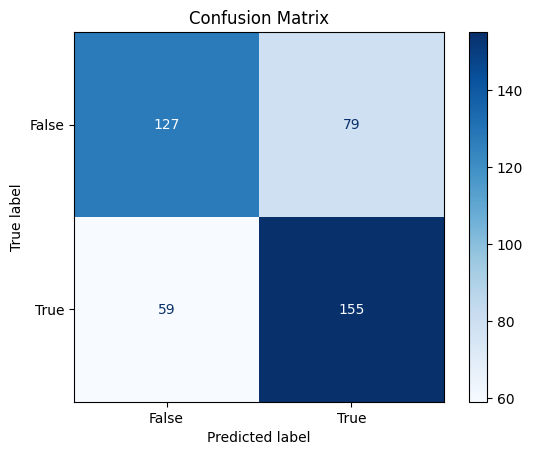

Accuracy of the model on the test data: 0.67


In [28]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.tolist())
        all_targets.extend(targets.tolist())

accuracy = accuracy_score(all_targets, all_preds)
print(f'Accuracy of the classifier on the test data: {accuracy:.2f}')

# Classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=["False", "True"]))

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()